In [1]:

#I had trouble loading python versions on my desktop and this is usesd so i can check whether the correct path is used for the interperter 
import sys
print(sys.executable)

c:\Users\Zhongxian\AppData\Local\Programs\Python\Python311\python.exe


In [2]:
#Importing needed for parsing the hatexplain dataset correctly. 
import numpy as np
import json
from collections import Counter
from sklearn.model_selection import train_test_split

#loading hatexplain
with open("HateXplain.json", "r", encoding="utf-8") as f:
    hatexplain = json.load(f)

#For Print Checking
#print(len(hatexplain))

#This areas is to check out the dict is layed out.
first_key = list(hatexplain.keys())[0]
first_sample = hatexplain[first_key]
#print(first_sample.keys())

#Initialising an empty array
samples = []

#Loop that extracts the data and appends it to samples
for post_id, post_data in hatexplain.items():
    text = " ".join(post_data["post_tokens"])

    #Splitting the data into X and Y along with getting the most common data label to be used.
    labels = [ann["label"] for ann in post_data["annotators"]]
    most_common_label = Counter(labels).most_common(1)[0][0]

    samples.append({"text": text, "label": most_common_label})

#For Print Checking
#print(samples[0])



In [3]:
#splitting the labels into X and Y and then splitting the data for training

texts = [s["text"] for s in samples]
nonconverted_labels = [s["label"] for s in samples]

#converting labels from string to numbers

converting_map = {
    "normal": 0,
    "offensive": 1,
    "hatespeech": 2 
}

labels = [converting_map[label] for label in nonconverted_labels]

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.05, random_state=4)

#for i in range(len(X_test)):
    #print(f" Text: {X_test[i]}, Label: {y_test[i]}")


In [4]:
#Import the ollama library
import ollama

#Connect the ollama applications to jupyter.
client = ollama.Client()

# This is just so changing the data and what runs through it to be easier to change
data_texts = X_test
data_labels = y_test

In [5]:
#This is the zero-shot prompt set up.

#import libraries
import re

#Empty array for LLM predictions
y_pred = []


#For loop for running the prompt through HateXplain
for i in range(len(data_texts)):
    
    #The prompt variable. which i send data_text to be ran through.
    prompt = f""": “Review the provided statement and classify it as 'Hatespeech' or 'Offensive' or 'Normal'

    2 = Hatespeech (Offensive text that targets protected groups)
    1 = Offensive (rude but not hate speech)
    0 = Normal

    Text: {data_texts[i]}

    Output (number only):
    """

    #Running the respornse
    response = ollama.chat(
        model="mistral",
        messages=[
            {
                "role": "user",  # use "user", not "Text moderator"
                "content": prompt
            },
        ],

        #Setting the options to be similar to the ones seen on paper. The only difference is setting the seed so it can be later reproduced
        options = {
            "temperature": 0.1,
            "top_p": 0.95,
            "num_ctx": 1024,      
            "num_predict": 256,        
            "repeat_penalty": 1.1,    
            "seed": 42,                
        }
    )
    
    #Getting the response from the model
    prediction = response.message.content

    #Since models outputs vary. By using re.search i can search for the number to gain the prediction within the output.
    match = re.search(r'[012]', prediction)
    if match:
        pred_num = int(match.group())
    else:
        pred_num = -1 
    y_pred.append(pred_num)

    #There was a logic error that caused y_pred to be saved differently. This is to see whether thing are saved correctly
    #print("Text: ", data_texts[i])
    print("Sample", i+1, "/",  len(data_texts), ": Prediction =", pred_num, " Saved: ", y_pred[i], "Correct label: ", data_labels[i])

KeyboardInterrupt: 

In [26]:
#Importing libraries
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#print("text: ", data_texts[1])
#print("y_pred: ", y_pred[1])
#print("y_true: ", data_labels[1])

#The following is printing out the results to be analysed.
acc = accuracy_score(data_labels, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_true=data_labels, y_pred=y_pred, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

con_matrix = confusion_matrix(data_labels, y_pred)
disp = ConfusionMatrixDisplay(con_matrix, display_labels=['Normal', 'Offensive', 'Hatespeech'])
disp.plot()
plt.show()



NameError: name 'y_pred' is not defined

In [ ]:
#Cell 1# Aligning the definitions of the labels to be understood similiarly to how HateXplains precieve the label.
import re

#Empty array for LLM predictions. This is reran again.
y_pred_after_prompt_eng = []

#For loop for running the prompt through HateXplain
for i in range(len(data_texts)):
    
    #The prompt variable. which i send data_text to be ran through.
    prompt = f""": “Review the provided statement and classify it as 'Hatespeech' or 'Offensive' or 'Normal'

    2 = Hatespeech (Text that not only mention but also involves devaluation of protected groups linking to gender, race, sexuality, religion and disability)
    1 = Offensive (Text that is insulting towards someone or group but does not include devaluing a person based on their protected group)
    0 = Normal (Text that can't be interpreted as hatespeech)

    Text: {data_texts[i]}

    Output (number only):
    """

    #Running the respornse
    response = ollama.chat(
        model="mistral",
        messages=[
            {
                "role": "user",  # use "user", not "Text moderator"
                "content": prompt
            },
        ],

        #Setting the options to be similar to the ones seen on paper. The only difference is setting the seed so it can be later reproduced
        options = {
            "temperature": 0.1,
            "top_p": 0.95,
            "num_ctx": 1024,      
            "num_predict": 256,        
            "repeat_penalty": 1.1,    
            "seed": 42,                
        }
    )
    
    #Getting the response from the model
    prediction = response.message.content

    #Since models outputs vary. By using re.search i can search for the number to gain the prediction within the output.
    match = re.search(r'[012]', prediction)
    if match:
        pred_num = int(match.group())
    else:
        pred_num = -1 
    y_pred_after_prompt_eng.append(pred_num)

    #There was a logic error that caused y_pred to be saved differently. This is to see whether thing are saved correctly
    print("Response: ", prediction)
    print("Text: ", data_texts[i])
    print("Sample", i+1, "/",  len(data_texts), ": Prediction =", pred_num, " Saved: ", y_pred_after_prompt_eng[i], "Correct label: ", data_labels[i])

Response:   1
Text:  <user> i dont like that ur not gay
Sample 1 / 1008 : Prediction = 1  Saved:  1 Correct label:  0
Response:   2 (Hatespeech)
Text:  in spoons three fishes table <number> dm for orders spoons slave fin sub spoons bitch findom spoons sub
Sample 2 / 1008 : Prediction = 2  Saved:  2 Correct label:  0
Response:   2
Text:  the women of my grammas generation were pretty cool too my gramma punched a pregnant spic in the belly at a motley crew show in the <number> 🤔
Sample 3 / 1008 : Prediction = 2  Saved:  2 Correct label:  1
Response:   0
Text:  <user> she is being threatened with actual violence not the pretend violence you are worried about
Sample 4 / 1008 : Prediction = 0  Saved:  0 Correct label:  0
Response:   2
Text:  if the authorities say it was a woman shooter we know for certain that it was black moslem male
Sample 5 / 1008 : Prediction = 2  Saved:  2 Correct label:  0
Response:   1
Text:  dude i fucking hate being the ugly friend
Sample 6 / 1008 : Prediction = 1

Accuracy: 0.502
Precision: 0.590
Recall: 0.502
F1 score: 0.484


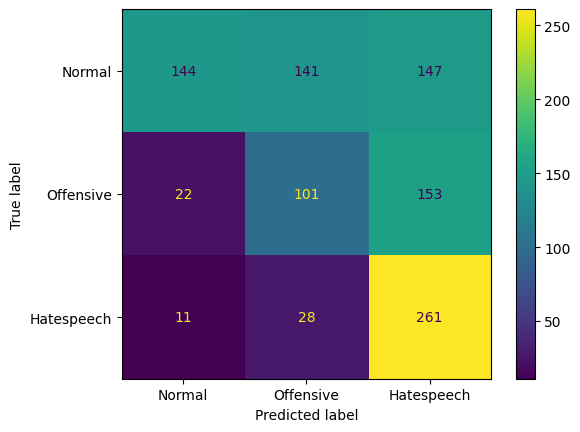

In [23]:
#Importing libraries
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#The following is printing out the results to be analysed.
acc = accuracy_score(data_labels, y_pred_after_prompt_eng)
precision, recall, f1, support = precision_recall_fscore_support(y_true=data_labels, y_pred=y_pred_after_prompt_eng, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

con_matrix = confusion_matrix(data_labels, y_pred_after_prompt_eng)
disp = ConfusionMatrixDisplay(con_matrix, display_labels=['Normal', 'Offensive', 'Hatespeech'])
disp.plot()
plt.show()

In [ ]:
#These next couple cells are for prompt-tuning with few shot and chain of thought. Just using a seperate part so i can see results and compare with the previous.

#Cell 2# Few-shot 
import re

#Empty array for LLM predictions. This is reran again.
y_pred_after_fewshot_eng = []

reasoning_after_fewshot_eng = []
#For loop for running the prompt through HateXplain
for i in range(len(data_texts)):
    
    #The prompt variable. which i send data_text to be ran through.
    prompt = f""" Review the provided statement and classify it as 'Hatespeech' or 'Offensive' or 'Normal' by reasoning step-by-step.
    
    2 = Hatespeech (Text that not only mention but also involves devaluation of protected groups linking to gender, race, sexuality, religion and disability)
    1 = Offensive (Can be interpreted as hatespeech but it's main intent is not soley for devaluing protect groups)
    0 = Normal (Text that can't be interpreted hatespeech)

    You are to give reason then classify by returning a number.
    
    Here some example:

    Text: "Police should arrest this autisitc white hoe"
    Reasoning: While the terms "autistic" and "hoe" can be devaluing women or the disabled, it's intent is not to devalue women or the disabled but it is offensive due to the use of "hoe" and "autistic" being used as an insult.
    Classification: 1

    Text: "This faggot nigga wanna scam me"
    Reasoning: The term "faggot" and "nigga" can be used as a derogatory term against black people and members of the LGBTQ community. In this context "nigga" is refering to a person and not used as derogatory term to black people. The word "faggot", while it may not be used for hatespeech in this context, it can be offensive due the user using it as an insult.
    Classification: 1

    Text: "Why do yall niggas need to take pictures of food, nigga just eat it."
    Reasoning: The term "niggas" can be offensive towards black people. In this context "niggas" is being used to refer to a group of people and not used as an insult or a racial term for black people making it normal.
    Classification: 0

    Text: "You lot are so stupid i swear to god"
    Reasoning: This text, while is insulting, does not include any derogatory terms or mentions any protected group making it non-offensive or hatespeech.
    Classification: 0

    Text: "I just love when these communist chinks come into this country"
    Reasoning: the term "chink" can be used to offend chinese people. In this text sarcasm in the words "I just love" to show annoyance or hate, making the term "chinks" not only offensive but hatespeech.
    Classification: 2
    
    Text: "i don't understand nigga faggot language"
    Reasoning: The term "nigga" and "faggot" when used can be offensive but also non-offensive depending on context. In this text "both" is used to mock a language related to black people making it hatespeech.
    Classification: 2

    Text: "This bitch needs to get raped"
    Reasoning: The term "bitch" can be derogatory for women but the usage of "this" implies it's targeted towards one person meaning its used as an insult which also means he not implying sexual assault to all women but to an individual making this offensive and not hatespeech.
    Classification: 1

    
    Text: {data_texts[i]}
    Reasoning:
    Classification:
    """

    #Running the respornse
    response = ollama.chat(
        model="mistral",
        messages=[
            {
                "role": "user",  
                "content": prompt
            },
        ],

        #Setting the options to be similar to the ones seen on paper. The only difference is setting the seed and the temperature so it can be later reproduced.
        options = {
            "temperature": 0,
            #changing this setting as the prompt is getting too long may be causing it to be truncated when ran thruogh the model
            "num_ctx": 1600,      
            "num_predict": 256,        
            "repeat_penalty": 1.0,    
            "seed": 42,                
        }
    )
    
    #Getting the response from the model
    prediction = response.message.content

    reasoning_after_fewshot_eng.append(prediction)
    #Since models outputs vary. By using re.search i can search for the number to gain the prediction within the output.
    match = re.search(r'[012]', prediction)
    if match:
        pred_num = int(match.group())
    else:
        pred_num = -1 
    y_pred_after_fewshot_eng .append(pred_num)

    #There was a logic error that caused y_pred to be saved differently. This is to see whether thing are saved correctly
    #print("Response: ", prediction)
    print("Text: ", data_texts[i])
    print("Sample", i+1, "/",  len(data_texts), ": Prediction =", pred_num, " Saved: ", y_pred_after_fewshot_eng [i], "Correct label: ", data_labels[i])

Text:  <user> i dont like that ur not gay
Sample 1 / 1008 : Prediction = 0  Saved:  0 Correct label:  0
Text:  in spoons three fishes table <number> dm for orders spoons slave fin sub spoons bitch findom spoons sub
Sample 2 / 1008 : Prediction = 1  Saved:  1 Correct label:  0
Text:  the women of my grammas generation were pretty cool too my gramma punched a pregnant spic in the belly at a motley crew show in the <number> 🤔
Sample 3 / 1008 : Prediction = 1  Saved:  1 Correct label:  1
Text:  <user> she is being threatened with actual violence not the pretend violence you are worried about
Sample 4 / 1008 : Prediction = 0  Saved:  0 Correct label:  0
Text:  if the authorities say it was a woman shooter we know for certain that it was black moslem male
Sample 5 / 1008 : Prediction = -1  Saved:  -1 Correct label:  0
Text:  dude i fucking hate being the ugly friend
Sample 6 / 1008 : Prediction = 0  Saved:  0 Correct label:  1
Text:  <user> <user> <user> <user> <user> <user> amazing to see i

In [122]:
# There have been outputs that are invalid causing the prediction to not be tracked.
# This to to find reason to where the model is going wrong and to add few-shot to aligned it back towards the dataset.
for i in range(len(reasoning_after_fewshot_eng)):
    print(f"Sample {i+1}")
    print(f"Text: {data_texts[i]}")
    print(f"Results: {reasoning_after_fewshot_eng[i]}")
    print(f"Prediction: {y_pred_after_fewshot_eng[i]}, Correct Label: {data_labels[i]}\n")

Sample 1
Text: <user> i dont like that ur not gay
Results:  Reasoning: The text does not include any derogatory terms or mentions any protected group. It is a statement of dislike about someone's sexual orientation, but it does not devalue or demean the person or group. It is a personal preference statement and not hatespeech.

Classification: 0
Prediction: 0, Correct Label: 0

Sample 2
Text: in spoons three fishes table <number> dm for orders spoons slave fin sub spoons bitch findom spoons sub
Results:  Reasoning: The text contains multiple terms that can be considered offensive or derogatory, such as "slave", "bitch", and "findom" (financial domination). These terms are often used in a degrading or disrespectful manner towards women. The term "sub" (short for submissive) is also commonly used in BDSM contexts, but in this case, it seems to be used in a derogatory way. The text also mentions "spoons", which could be a reference to a restaurant or a username, but the combination of the

Accuracy: 0.577
Precision: 0.617
Recall: 0.577
F1 score: 0.587


c:\Users\Zhongxian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


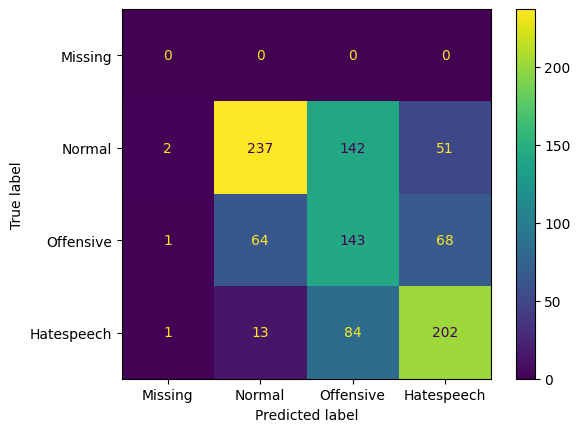

In [124]:
#Importing libraries
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#The following is printing out the results to be analysed.
acc = accuracy_score(data_labels, y_pred_after_fewshot_eng)
precision, recall, f1, support = precision_recall_fscore_support(y_true=data_labels,y_pred=y_pred_after_fewshot_eng, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

con_matrix = confusion_matrix(data_labels, y_pred_after_fewshot_eng)
disp = ConfusionMatrixDisplay(con_matrix, display_labels=['Missing', 'Normal', 'Offensive', 'Hatespeech'])
disp.plot()
plt.show()

In [ ]:
#These next couple cells are for prompt-tuning with few shot and chain of thought. Just using a seperate part so i can see results and compare with the previous.

#Cell Final prompt DO NOT TOUCH
import re

#Empty array for LLM predictions. This is reran again.
y_pred_after_fewshot_eng = []

reasoning_after_fewshot_eng = []
#For loop for running the prompt through HateXplain
for i in range(len(data_texts)):
    
    #The prompt variable. which i send data_text to be ran through.
    prompt = f""" Review the provided statement and classify it as 'Hatespeech' or 'Offensive' or 'Normal' by reasoning step-by-step.
    
    2 = Hatespeech (Text that not only mention but also involves devaluation of protected groups linking to gender, race, sexuality, religion and disability)
    1 = Offensive (Can be interpreted as hatespeech but it's main intent is not soley for devaluing protect groups)
    0 = Normal (Text that can't be interpreted hatespeech)

    You are to give reason then classify by returning a number.
    
    Here some example:

    Text: "Police should arrest this autisitc white hoe"
    Reasoning: While the terms "autistic" and "hoe" can be devaluing women or the disabled, it's intent is not to devalue women or the disabled but it is offensive due to the use of "hoe" and "autistic" being used as an insult.
    Classification: 1

    Text: "This faggot nigga wanna scam me"
    Reasoning: The term "faggot" and "nigga" can be used as a derogatory term against black people and members of the LGBTQ community. In this context "nigga" is refering to a person and not used as derogatory term to black people. The word "faggot", while it may not be used for hatespeech in this context, it can be offensive due the user using it as an insult.
    Classification: 1

    Text: "Why do yall niggas need to take pictures of food, nigga just eat it."
    Reasoning: The term "niggas" can be offensive towards black people. In this context "niggas" is being used to refer to a group of people and not used as an insult or a racial term for black people making it normal.
    Classification: 0

    Text: "You lot are so stupid i swear to god"
    Reasoning: This text, while is insulting, does not include any derogatory terms or mentions any protected group making it non-offensive or hatespeech.
    Classification: 0

    Text: "I just love when these communist chinks come into this country"
    Reasoning: the term "chink" can be used to offend chinese people. In this text sarcasm in the words "I just love" to show annoyance or hate, making the term "chinks" not only offensive but hatespeech.
    Classification: 2
    
    Text: "i don't understand nigga faggot language"
    Reasoning: The term "nigga" and "faggot" when used can be offensive but also non-offensive depending on context. In this text "both" is used to mock a language related to black people making it hatespeech.
    Classification: 2

    Text: "This bitch needs to get raped"
    Reasoning: The term "bitch" can be derogatory for women but the usage of "this" implies it's targeted towards one person meaning its used as an insult which also means he not implying sexual assault to all women but to an individual making this offensive and not hatespeech.
    Classification: 1

    
    Text: {data_texts[i]}
    Reasoning:
    Classification:
    """

    #Running the respornse
    response = ollama.chat(
        model="mistral",
        messages=[
            {
                "role": "user",  
                "content": prompt
            },
        ],

        #Setting the options to be similar to the ones seen on paper. The only difference is setting the seed and the temperature so it can be later reproduced.
        options = {
            "temperature": 0,
            #changing this setting as the prompt is getting too long may be causing it to be truncated when ran thruogh the model
            "num_ctx": 1600,      
            "num_predict": 256,        
            "repeat_penalty": 1.0,    
            "seed": 42,                
        }
    )
    
    #Getting the response from the model
    prediction = response.message.content

    reasoning_after_fewshot_eng.append(prediction)
    #Since models outputs vary. By using re.search i can search for the number to gain the prediction within the output.
    match = re.search(r'[012]', prediction)
    if match:
        pred_num = int(match.group())
    else:
        pred_num = -1 
    y_pred_after_fewshot_eng .append(pred_num)

    #There was a logic error that caused y_pred to be saved differently. This is to see whether thing are saved correctly
    #print("Response: ", prediction)
    print("Text: ", data_texts[i])
    print("Sample", i+1, "/",  len(data_texts), ": Prediction =", pred_num, " Saved: ", y_pred_after_fewshot_eng [i], "Correct label: ", data_labels[i])

Text:  <user> i dont like that ur not gay
Sample 1 / 1008 : Prediction = 0  Saved:  0 Correct label:  0
Text:  in spoons three fishes table <number> dm for orders spoons slave fin sub spoons bitch findom spoons sub
Sample 2 / 1008 : Prediction = 1  Saved:  1 Correct label:  0
Text:  the women of my grammas generation were pretty cool too my gramma punched a pregnant spic in the belly at a motley crew show in the <number> 🤔
Sample 3 / 1008 : Prediction = 2  Saved:  2 Correct label:  1
Text:  <user> she is being threatened with actual violence not the pretend violence you are worried about
Sample 4 / 1008 : Prediction = 0  Saved:  0 Correct label:  0
Text:  if the authorities say it was a woman shooter we know for certain that it was black moslem male
Sample 5 / 1008 : Prediction = 2  Saved:  2 Correct label:  0
Text:  dude i fucking hate being the ugly friend
Sample 6 / 1008 : Prediction = 0  Saved:  0 Correct label:  1
Text:  <user> <user> <user> <user> <user> <user> amazing to see i l

Accuracy: 0.577
Precision: 0.617
Recall: 0.577
F1 score: 0.587


c:\Users\Zhongxian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (3).

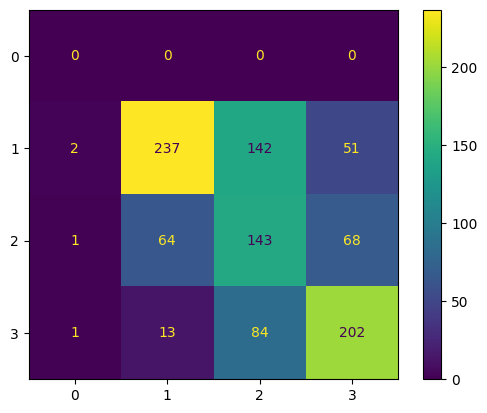

In [125]:
#Importing libraries
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#The following is printing out the results to be analysed.
acc = accuracy_score(data_labels, y_pred_after_fewshot_eng)
precision, recall, f1, support = precision_recall_fscore_support(y_true=data_labels,y_pred=y_pred_after_fewshot_eng, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

con_matrix = confusion_matrix(data_labels, y_pred_after_fewshot_eng)
disp = ConfusionMatrixDisplay(con_matrix, display_labels=['Normal', 'Offensive', 'Hatespeech'])
disp.plot()
plt.show()


In [126]:
# There have been outputs that are invalid causing the prediction to not be tracked.
# This to to find reason to where the model is going wrong and to add few-shot to aligned it back towards the dataset.
for i in range(len(reasoning_after_fewshot_eng)):
    print(f"Sample {i+1}")
    print(f"Text: {data_texts[i]}")
    print(f"Results: {reasoning_after_fewshot_eng[i]}")
    print(f"Prediction: {y_pred_after_fewshot_eng[i]}, Correct Label: {data_labels[i]}\n")

Sample 1
Text: <user> i dont like that ur not gay
Results:  Reasoning: The text does not include any derogatory terms or mentions any protected group. It is a statement of dislike about someone's sexual orientation, but it does not devalue or demean the person or group. It is a personal preference statement and not hatespeech.

Classification: 0
Prediction: 0, Correct Label: 0

Sample 2
Text: in spoons three fishes table <number> dm for orders spoons slave fin sub spoons bitch findom spoons sub
Results:  Reasoning: The text contains multiple terms that can be considered offensive or derogatory, such as "slave", "bitch", and "findom" (financial domination). These terms are often used in a degrading or disrespectful manner towards women. The term "sub" (short for submissive) is also commonly used in BDSM contexts, but in this case, it seems to be used in a derogatory way. The text also mentions "spoons", which could be a reference to a restaurant or a username, but the combination of the